# 6.1 텍스트 데이터 다루기

이 노트북은 [케라스 창시자에게 배우는 딥러닝](https://tensorflow.blog/케라스-창시자에게-배우는-딥러닝/) 책의 6장 1절의 코드 예제입니다. 책에는 더 많은 내용과 그림이 있습니다. 이 노트북에는 소스 코드에 관련된 설명만 포함합니다. 이 노트북의 설명은 케라스 버전 2.3.1에 맞추어져 있습니다. 케라스 최신 버전이 릴리스되면 노트북을 다시 테스트하기 때문에 설명과 코드의 결과가 조금 다를 수 있습니다.

----

In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.1'

텍스트는 가장 흔한 시퀀스 형태의 데이터입니다. 텍스트는 단어의 시퀀스나 문자의 시퀀스로 이해할 수 있습니다. 보통 단어 수준으로 작업하는 경우가 많습니다. 다음 절에서 소개할 시퀀스 처리용 딥러닝 모델은 텍스트를 사용하여 기초적인 자연어 이해(natural language understanding) 문제를 처리할 수 있습니다. 이런 모델은 문서 분류, 감성 분석, 저자 식별, (제한된 범위의) 질문 응답(Question Answering, QA)  등의 애플리케이션에 적합합니다. 물론 이런 딥러닝 모델이 사람처럼 진짜 텍스트를 이해하는 것은 아닙니다. 이 장을 읽을 때 이런 점을 유념해 주세요. 이런 모델은 문자 언어(written language)에 대한 통계적 구조를 만들어 간단한 텍스트 문제를 해결합니다. 컴퓨터 비전이 픽셀에 적용한 패턴 인식(pattern recognition)인 것처럼 자연어 처리(natural language processing)를 위한 딥러닝은 단어, 문장, 문단에 적용한 패턴 인식입니다.

다른 모든 신경망과 마찬가지로 텍스트 원본을 입력으로 사용하지 못합니다. 딥러닝 모델은 수치형 텐서만 다룰 수 있습니다. 텍스트를 수치형 텐서로 변환하는 과정을  텍스트 벡터화(vectorizing text)라고 합니다. 여기에는 여러 가지 방식이 있습니다.

- 텍스트를 단어로 나누고 각 단어를 하나의 벡터로 변환합니다.
- 텍스트를 문자로 나누고 각 문자를 하나의 벡터로 변환합니다.
- 텍스트에서 단어나 문자의  n-그램(n-gram)을 추출하여 각 n-그램을 하나의 벡터로 변환합니다. n-그램은 연속된 단어나 문자의 그룹으로 텍스트에서 단어나 문자를 하나씩 이동하면서 추출합니다.

텍스트를 나누는 이런 단위(단어, 문자, n-그램)를  토큰(token)이라고 합니다. 그리고 텍스트를 토큰으로 나누는 작업을  토큰화(tokenization)라고 합니다. 모든 텍스트 벡터화 과정은 어떤 종류의 토큰화를 적용하고 생성된 토큰에 수치형 벡터를 연결하는 것으로 이루어집니다. 이런 벡터는 시퀀스 텐서로 묶여져서 심층 신경망에 주입됩니다. 토큰과 벡터를 연결하는 방법은 여러 가지가 있습니다. 이 절에서 두 가지 주요 방법을 소개하겠습니다. 토큰의  원-핫 인코딩(one-hot encoding)과  토큰 임베딩(token embedding)(일반적으로 단어에 대해서만 사용되므로  단어 임베딩(word embedding)이라고도 부릅니다)입니다. 이 절에서 이 기법들을 설명하고 이를 이용하여 원본 텍스트를 케라스에서 사용할 수 있도록 넘파이 배열로 바꾸는 방법을 소개하겠습니다.

![나타낼 수 없음](https://dpzbhybb2pdcj.cloudfront.net/chollet/Figures/06fig01.jpg)  
_그림 6-1. 텍스트에서 토큰으로, 토큰에서 벡터로_

---

**Note**  n-그램과 BoW

단어 n-그램은 문장에서 추출한 N개(또는 그 이하)의 연속된 단어 그룹입니다. 같은 개념이 단어 대신 문자에도 적용될 수 있습니다.

다음은 간단한 예입니다. “The cat sat on the mat.”이란 문장을 생각해 보죠. 이 문장은 다음 2-그램의 집합으로 분해할 수 있습니다.

{"The", "The cat", "cat", "cat sat", "sat",
  "sat on", "on", "on the", "the", "the mat", "mat"}

또 다음 3-그램의 집합으로도 분해할 수 있습니다.

{"The", "The cat", "cat", "cat sat", "The cat sat",
  "sat", "sat on", "on", "cat sat on", "on the", "the",
  "sat on the", "the mat", "mat", "on the mat"}

이런 집합을 각각 2-그램 가방(bag of 2- gram) 또는 3-그램 가방(bag of 3- gram)이라고 합니다. 가방(bag)이란 용어는 다루고자 하는 것이 리스트나 시퀀스가 아니라 토큰의 집합이라는 사실을 의미합니다. 이 토큰에는 특정한 순서가 없습니다. 이런 종류의 토큰화 방법을 BoW(Bag-of-Words)라고 합니다.

BoW가 순서가 없는 토큰화 방법이기 때문에(생성된 토큰은 시퀀스가 아니라 집합으로 간주되고 문장의 일반적인 구조가 사라집니다) 딥러닝 모델보다 얕은 학습 방법의 언어 처리 모델에 사용되는 경향이 있습니다. n-그램을 추출하는 것은 일종의 특성 공학입니다. 딥러닝은 유연하지 못하고 불안정한 이런 방식을 계층적인 특성 학습으로 대체합니다. 나중에 소개할 순환 신경망과 1D 컨브넷으로 단어와 문자 그룹에 대한 특성을 학습할 수 있습니다. 이 방식들은 그룹들을 명시적으로 알려 주지 않아도 연속된 단어나 문자의 시퀀스를 봄으로써 학습합니다. 이런 이유 때문에 이 책에서는 n-그램을 더 다루지 않습니다. 하지만 로지스틱 회귀나 랜덤 포레스트 같은 얕은 학습 방법의 텍스트 처리 모델을 사용할 때는 강력하고 아주 유용한 특성 공학 방법임을 기억해 두세요.[^1]

[^1]: BoW는 각 샘플을 어휘 사전 크기의 벡터로 변환합니다. 이 벡터의 원소는 특정 토큰 하나에 대응하며 순서가 없습니다. 변환은 샘플에 나타난 토큰의 인덱스 위치를 1로 바꾸는 식입니다. 전체 데이터셋의 크기는 (samples, vocabulary_size)가 됩니다. BoW와 n-그램을 사용한 텍스트 분석은 <파이썬 라이브러리를 활용한 머신러닝>(한빛미디어, 2017)의 7장을 참고하세요.

---

## 6.1.1 단어와 문자의 원-핫 인코딩

원-핫 인코딩은 토큰을 벡터로 변환하는 가장 일반적이고 기본적인 방법입니다. 3장에서 IMDB와 로이터 예제에서 이를 보았습니다(단어의 원-핫 인코딩을 사용했습니다). 모든 단어에 고유한 정수 인덱스를 부여하고 이 정수 인덱스 i를 크기가 N(어휘 사전의 크기)인 이진 벡터로 변환합니다. 이 벡터는 i번째 원소만 1이고 나머지는 모두 0입니다.

물론 원-핫 인코딩은 문자 수준에서도 적용할 수 있습니다. 원-핫 인코딩이 무엇이고 어떻게 구현하는지 명확하게 설명하기 위해 단어와 문자에 대한 간단한 예를 만들었습니다.

In [2]:
# 코드 6-1. 단어 수준의 원-핫 인코딩하기(간단한 예)
import numpy as np

# 초기 데이터: 각 원소가 샘플입니다
# (이 예에서 하나의 샘플이 하나의 문장입니다. 하지만 문서 전체가 될 수도 있습니다)
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# 데이터에 있는 모든 토큰의 인덱스를 구축합니다
token_index = {}
for sample in samples:
    # split() 메서드를 사용해 샘플을 토큰으로 나눕니다.
    # 실전에서는 구둣점과 특수 문자도 사용합니다.
    for word in sample.split():
        if word not in token_index:
            # 단어마다 고유한 인덱스를 할당합니다.
            token_index[word] = len(token_index) + 1
            # 인덱스 0은 사용하지 않습니다.

# 샘플을 벡터로 변환합니다.
# 각 샘플에서 max_length 까지 단어만 사용합니다.
max_length = 10

# 결과를 저장할 배열입니다
results = np.zeros((len(samples), max_length, max(token_index.values()) + 1))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1.

[^2]

[^2]: 관례상 인덱스 0은 단어가 아닌 토큰을 위해 남겨 둡니다. 예를 들어 코드 6- 6에서 시퀀스를 패딩할 때 0을 사용하여 채웁니다. 코드 6-3에서 Tokenizer(num_words=1000)처럼 지정하면 인덱스 0을 제외하고 최대 999개까지 단어를 사용합니다. num_words 매개변수를 지정하지 않으면 고유한 단어의 전체 개수 + 1(인덱스 0)이 원-핫 인코딩의 길이가 됩니다.

In [3]:
# 코드 6-2. 문자 수준 원-핫 인코딩하기(간단한 예)
import string

samples = ['The cat sat on the mat.', 'The dog ate my homework.']
characters = string.printable  # 출력 가능한 모든 아스키(ASCII) 문자
token_index = dict(zip(characters, range(1, len(characters) + 1)))

max_length = 50
results = np.zeros((len(samples), max_length, max(token_index.values()) + 1))
for i, sample in enumerate(samples):
    for j, character in enumerate(sample[:max_length]):
        index = token_index.get(character)
        results[i, j, index] = 1.

케라스에는 원본 텍스트 데이터를 단어 또는 문자 수준의 원-핫 인코딩으로 변환해주는 유틸리티가 있습니다. 특수 문자를 제거하거나 빈도가 높은 N개의 단어만을 선택(입력 벡터 공간이 너무 커지지 않도록 하기 위한 일반적인 제한 방법입니다)하는 등 여러 가지 중요한 기능들이 있기 때문에 이 유틸리티를 사용하는 것이 좋습니다.[^3]

[^3]: 코드 6-1과 코드 6-2의 `results` 배열의 크기는 `(samples, max_length, token_length + 1)`이고 코드 6-3의 `one_hot_results` 크기는 `(samples, max_length)`입니다. 케라스의 `Tokenizer` 클래스가 만드는 원-핫 인코딩은 1-그램의 BoW와 같습니다.

In [4]:
# 코드 6-3. 케라스를 사용한 단어 수준의 원-핫 인코딩하기
from keras.preprocessing.text import Tokenizer

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# 가장 빈도가 높은 1,000개의 단어만 선택하도록 Tokenizer 객체를 만듭니다.
tokenizer = Tokenizer(num_words=1000)
# 단어 인덱스를 구축합니다.
tokenizer.fit_on_texts(samples)

# 문자열을 정수 인덱스의 리스트로 변환합니다.
sequences = tokenizer.texts_to_sequences(samples)

# 직접 원-핫 이진 벡터 표현을 얻을 수 있습니다.
# 원-핫 인코딩 외에 다른 벡터화 방법들도 제공합니다!
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')

# 계산된 단어 인덱스를 구합니다.
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 9 unique tokens.


[^4]

[^4]: `texts_to_matrix()` 메서드는 텍스트를 시퀀스 리스트로 바꾸어 주는 `texts_to_sequences()` 메서드와 시퀀스 리스트를 넘파이 배열로 바꾸어 주는 `sequences_to_matrix()` 메서드를 차례대로 호출합니다. `mode` 매개변수에서 지원하는 값은 기본값 `‘binary’` 외에 `‘count’`, `‘freq’`, `‘tfidf’`가 있습니다. `‘count’`는 단어의 출현 횟수를 사용하고 `‘freq’`는 출현 횟수를 전체 시퀀스의 길이로 나누어 정규화합니다. `‘tfidf’`는 [TF-IDF 방식](https://bit.ly/2tNbg7G)을 의미합니다.

원-핫 인코딩의 변종 중 하나는 원-핫 해싱(one-hot hashing) 기법입니다. 이 방식은 어휘 사전에 있는 고유한 토큰의 수가 너무 커서 모두 다루기 어려울 때 사용합니다. 각 단어에 명시적으로 인덱스를 할당하고 이 인덱스를 딕셔너리에 저장하는 대신에 단어를 해싱하여 고정된 크기의 벡터로 변환합니다. 일반적으로 간단한 해싱 함수를 사용합니다. 이 방식의 주요 장점은 명시적인 단어 인덱스[^5]가 필요 없기 때문에 메모리를 절약하고 온라인 방식으로 데이터를 인코딩할 수 있습니다(전체 데이터를 확인하지 않고 토큰을 생성할 수 있습니다). 한 가지 단점은 해시 충돌(hash collision)입니다. 2개의 단어가 같은 해시를 만들면 이를 바라보는 머신 러닝 모델은 단어 사이의 차이를 인식하지 못합니다. 해싱 공간의 차원이 해싱될 고유 토큰의 전체 개수보다 훨씬 크면 해시 충돌의 가능성은 감소합니다.

[^5]: 코드 6-3의 `word_index`를 말합니다. 이 딕셔너리의 키(key)는 단어고 값(value)은 단어의 인덱스입니다.

In [5]:
# 코드 6-4. 해싱 기법을 사용한 단어 수준의 원-핫 인코딩하기(간단한 예)
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# 단어를 크기가 1,000인 벡터로 저장합니다.
# 1,000개(또는 그이상)의 단어가 있다면 해싱 충돌이 늘어나고 인코딩의 정확도가 감소될 것입니다
dimensionality = 1000
max_length = 10

results = np.zeros((len(samples), max_length, dimensionality))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        # 단어를 해싱하여 0과 1,000 사이의 랜덤한 정수 인덱스로 변환합니다.
        index = abs(hash(word)) % dimensionality
        results[i, j, index] = 1.

## 6.1.2 단어 임베딩 사용하기

단어와 벡터를 연관 짓는 강력하고 인기 있는 또 다른 방법은 단어 임베딩이라는 밀집 단어 벡터(word vector)를 사용하는 것입니다. 원-핫 인코딩으로 만든 벡터는 희소(sparse)하고(대부분 0으로 채워집니다) 고차원입니다(어휘 사전에 있는 단어의 수와 차원이 같습니다). 반면에 단어 임베딩은 저차원의 실수형 벡터입니다(희소 벡터의 반대인 밀집 벡터입니다). 그림 6-2를 참고하세요. 원-핫 인코딩으로 얻은 단어 벡터와 달리 단어 임베딩은 데이터로부터 학습됩니다. 보통 256차원, 512차원 또는 큰 어휘 사전을 다룰 때는 1,024차원의 단어 임베딩을 사용합니다. 반면에 원-핫 인코딩은 (20,000개의 토큰으로 이루어진 어휘 사전을 만들려면) 20,000차원 또는 그 이상의 벡터일 경우가 많습니다. 따라서 단어 임베딩이 더 많은 정보를 적은 차원에 저장합니다.

![나타낼 수 없음](https://dpzbhybb2pdcj.cloudfront.net/chollet/Figures/06fig02.jpg)  
_그림 6-2. 원-핫 인코딩이나 해싱으로 얻은 단어 표현은 희소하고 고차원이고 수동으로 인코딩되지만, 단어 임베딩은 조밀하고 비교적 저차원이며 데이터로부터 학습된다_

단어 임베딩을 만드는 방법은 두 가지입니다.

- (문서 분류나 감성 예측 같은) 관심 대상인 문제와 함께 단어 임베딩을 학습합니다. 이런 경우에는 랜덤한 단어 벡터로 시작해서 신경망의 가중치를 학습하는 것과 같은 방식으로 단어 벡터를 학습합니다.
- 풀려는 문제가 아니고 다른 머신 러닝 작업에서 미리 계산된 단어 임베딩을 로드합니다. 이를 사전 훈련된 단어 임베딩(pretrained word embedding)이라고 합니다.

두 가지 모두 살펴보겠습니다.

### `Embedding` 층을 사용해 단어 임베딩 학습하기

단어와 밀집 벡터를 연관짓는 가장 간단한 방법은 랜덤하게 벡터를 선택하는 것입니다. 이 방식의 문제점은 임베딩 공간이 구조적이지 않다는 것입니다. 예를 들어 accurate와 exact 단어가 대부분 문장에서 비슷한 의미로 사용되지만 완전히 다른 임베딩을 가지게 됩니다. 심층 신경망이 이런 임의의 구조적이지 않은 임베딩 공간을 이해하기는 어렵습니다.

단어 벡터 사이에 조금 더 추상적이고 기하학적인 관계를 얻으려면 단어 사이에 있는 의미 관계를 반영해야 합니다. 단어 임베딩은 언어를 기하학적 공간에 매핑하는 것입니다. 예를 들어 잘 구축된 임베딩 공간에서는 동의어가 비슷한 단어 벡터로 임베딩될 것입니다. 일반적으로 두 단어 벡터 사이의 거리(L2 거리)는 이 단어 사이의 의미 거리와 관계되어 있습니다(멀리 떨어진 위치에 임베딩된 단어의 의미는 서로 다르고 반면 비슷한 단어들은 가까이 임베딩됩니다). 거리외에 임베딩 공간의 특정 방향도 의미를 가질 수 있습니다. 확실한 이해를 위해 구체적인 예를 살펴보겠습니다.

그림 6-3에서 4개의 단어 cat, dog, wolf, tiger가 2D 평면에 임베딩되어 있습니다. 이 벡터 표현을 사용하여 단어 간의 의미 관계를 기하학적 변환으로 인코딩할 수 있습니다. 예를 들어 cat에서 tiger로 이동하는 것과 dog에서 wolf로 이동하는 것을 같은 벡터로 나타낼 수 있습니다. 이 벡터는 ‘애완동물에서 야생 동물로 이동’하는 것으로 해석할 수 있습니다. 비슷하게 다른 벡터로 dog에서 cat으로 이동하는 것과 wolf에서 tiger로 이동하는 것을 나타내면 ‘개과에서 고양이과로 이동’하는 벡터로 해석할 수 있습니다.

![나타낼 수 없음](https://dpzbhybb2pdcj.cloudfront.net/chollet/Figures/06fig03.jpg)  
_그림 6-3. 단어 임베딩 공간의 간단한 예_

실제 단어 임베딩 공간에서 의미 있는 기하학적 변환의 일반적인 예는 '성별' 벡터와 '복수(plural)' 벡터입니다. 예를 들어 'king' 벡터에 'female' 벡터를 더하면 'queen' 벡터가 됩니다. 'plural' 벡터를 더하면 'kings'가 됩니다. 단어 임베딩 공간은 전형적으로 이런 해석 가능하고 잠재적으로 유용한 수천 개의 벡터를 특성으로 가집니다.

사람의 언어를 완벽하게 매핑해서 어떤 자연어 처리 작업에도 사용할 수 있는 이상적인 단어 임베딩 공간이 있을까요? 아마도 가능하겠지만 아직까지 이런 종류의 공간은 만들지 못했습니다. 사람의 언어에도 그런 것은 없습니다. 세상에는 많은 다른 언어가 있고 언어는 특정 문화와 환경을 반영하기 때문에 서로 동일하지 않습니다. 실제로 좋은 단어 임베딩 공간을 만드는 것은 문제에 따라 크게 달라집니다. 영어로 된 영화 리뷰 감성 분석 모델을 위한 완벽한 단어 임베딩 공간은 영어로 된 법률 문서 분류 모델을 위한 완벽한 임베딩 공간과 다를 것 같습니다. 특정 의미 관계의 중요성이 작업에 따라 다르기 때문입니다.

따라서 새로운 작업에는 새로운 임베딩을 학습하는 것이 타당합니다. 다행히 역전파를 사용해 쉽게 만들 수 있고 케라스를 사용하면 더 쉽습니다. `Embedding` 층의 가중치를 학습하면 됩니다.

In [6]:
# 코드 6-5. Embedding 층의 객체 생성하기
from keras.layers import Embedding

# Embedding 층은 적어도 두 개의 매개변수를 받습니다.
# 가능한 토큰의 개수(여기서는 1,000으로 단어 인덱스 최댓값 + 1입니다)와 임베딩 차원(여기서는 64)입니다
embedding_layer = Embedding(1000, 64)

[^6]

[^6]: 이 `Embedding` 층의 가중치 크기는 `(1000, 64)`입니다. 인덱스 0은 사용하지 않으므로 단어 인덱스는 1~999 사이입니다.

`Embedding` 층을 (특정 단어를 나타내는) 정수 인덱스를 밀집 벡터로 매핑하는 딕셔너리로 이해하는 것이 가장 좋습니다. 정수를 입력으로 받아 내부 딕셔너리에서 이 정수에 연관된 벡터를 찾아 반환합니다. 딕셔너리 탐색은 효율적으로 수행됩니다.[^7]

[^7]: 텐서플로 백엔드를 사용할 경우 `tf.nn.embedding_lookup()` 함수를 사용하여 병렬 처리됩니다.

![나타낼 수 없음](https://dpzbhybb2pdcj.cloudfront.net/chollet/Figures/06fig04.jpg)  
_그림 6-4. Embedding 층_

`Embedding` 층은 크기가 `(samples, sequence_length)`인 2D 정수 텐서를 입력으로 받습니다. 각 샘플은 정수의 시퀀스입니다. 가변 길이의 시퀀스를 임베딩할 수 있습니다. 예를 들어 위 예제의 `Embedding` 층에 `(32, 10)` 크기의 배치(길이가 10인 시퀀스 32개로 이루어진 배치)나 `(64, 15)` 크기의 배치(길이가 15인 시퀀스 64개로 이루어진 배치)를 주입할 수 있습니다. 배치에 있는 모든 시퀀스는 길이가 같아야 하므로(하나의 텐서에 담아야 하기 때문에) 작은 길이의 시퀀스는 0으로 패딩되고 길이가 더 긴 시퀀스는 잘립니다.

`Embedding` 층은 크기가 `(samples, sequence_length, embedding_dimensionality)`인 3D 실수형 텐서를 반환합니다. 이런 3D 텐서는 RNN 층이나 1D 합성곱 층에서 처리됩니다(둘 다 이어지는 절에서 소개하겠습니다).

`Embedding` 층의 객체를 생성할 때 가중치(토큰 벡터를 위한 내부 딕셔너리)는 다른 층과 마찬가지로 랜덤하게 초기화됩니다. 훈련하면서 이 단어 벡터는 역전파를 통해 점차 조정되어 이어지는 모델이 사용할 수 있도록 임베팅 공간을 구성합니다. 훈련이 끝나면 임베딩 공간은 특정 문제에 특화된 구조를 많이 가지게 됩니다.

이를 익숙한 IMDB 영화 리뷰 감성 예측 문제에 적용해 보죠. 먼저 데이터를 준비합니다. 영화 리뷰에서 가장 빈도가 높은 10,000개의 단어를 추출하고(처음 이 데이터셋으로 작업했던 것과 동일합니다) 리뷰에서 20개 단어 이후는 버립니다. 이 네트워크는 10,000개의 단어에 대해 8 차원의 임베딩을 학습하여 정수 시퀀스 입력(2D 정수 텐서)를 임베딩 시퀀스(3D 실수형 텐서)로 바꿀 것입니다. 그 다음 이 텐서를 2D로 펼쳐서 분류를 위한 `Dense` 층을 훈련하겠습니다.

In [7]:
# 코드 6-6. Embedding 층에 사용할 IMDB 데이터 로드하기
from keras.datasets import imdb
from keras import preprocessing

# 특성으로 사용할 단어의 수
max_features = 10000
# 사용할 텍스트의 길이(가장 빈번한 max_features 개의 단어만 사용합니다)
maxlen = 20

# 정수 리스트로 데이터를 로드합니다.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# 리스트를 (samples, maxlen) 크기의 2D 정수 텐서로 변환합니다.
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

[^8]

[^8]: `pad_sequences()` 함수에는 패딩을 넣을 위치를 지정하는 `padding` 매개변수가 있습니다. 기본값 `‘pre’`는 시퀀스 왼쪽에 패딩이 추가되고, `‘post’`는 오른쪽에 패딩이 추가됩니다. 이 예에서는 문장에서 20개의 단어만 사용하므로 실제 패딩되는 샘플은 없습니다.

In [8]:
# 코드 6-7. IMDB 데이터에 Embedding 층과 분류기 사용하기
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()
# 나중에 임베딩된 입력을 Flatten 층에서 펼치기 위해 Embedding 층에 input_length를 지정합니다.
model.add(Embedding(10000, 8, input_length=maxlen))
# Embedding 층의 출력 크기는 (samples, maxlen, 8)가 됩니다.

# 3D 임베딩 텐서를 (samples, maxlen * 8) 크기의 2D 텐서로 펼칩니다.
model.add(Flatten())

# 분류기를 추가합니다.
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 2s 117us/step - loss: 0.6632 - acc: 0.6320 - val_loss: 0.6089 - val_acc: 0.7036
Epoch 2/10
20000/20000 [==============================] - 2s 99us/step - loss: 0.5349 - acc: 0.7545 - val_loss: 0.5220 - val_acc: 0.7312
Epoch 3/10
20000/20000 [==============================] 

[^9]

[^9]: `Embedding` 층에 `input_length`를 지정하지 않으면 출력 텐서의 차원이 `(None, None, 8)`이 됩니다. `Flatten` 층을 사용하려면 첫 번째 배치 차원을 제외하고 나머지 차원이 결정되어야 하므로 `input_length`를 지정하여 `(None, 20, 8)`로 만듭니다.

약 75% 정도의 검증 정확도가 나옵니다. 리뷰에서 20개의 단어만 사용한 것치고 꽤 좋은 결과입니다. 하지만 임베딩 시퀀스를 펼치고 하나의 `Dense` 층을 훈련했으므로 입력 시퀀스에 있는 각 단어를 독립적으로 다루었습니다. 단어 사이의 관계나 문장의 구조를 고려하지 않았습니다(예를 들어 이 모델은 “this movie is a bomb”와 “this movie is the bomb”를 부정적인 리뷰로 동일하게 다룰 것입니다[^10]). 각 시퀀스 전체를 고려한 특성을 학습하도록 임베딩 층 위에 순환 층이나 1D 합성곱 층을 추가하는 것이 좋습니다. 다음 절에서 이에 관해 집중적으로 다루겠습니다.

[^10]: “this movie is the bomb”은 영화가 아주 좋다는 긍정의 뜻입니다.

### 사전 훈련된 단어 임베딩 사용하기

이따금 훈련 데이터가 부족하면 작업에 맞는 단어 임베딩을 학습할 수 없습니다. 이럴 땐 어떻게 해야 할까요?

풀려는 문제와 함께 단어 임베딩을 학습하는 대신에 미리 계산된 임베딩 공간에서 임베딩 벡터를 로드할 수 있습니다. 이런 임베딩 공간은 뛰어난 구조와 유용한 성질을 가지고 있어서 언어 구조의 일반적인 측면을 잡아낼 수 있습니다. 자연어 처리에서 사전 훈련된 단어 임베딩을 사용하는 이유는 이미지 분류 문제에서 사전 훈련된 컨브넷을 사용하는 이유와 거의 동일합니다. 충분한 데이터가 없어서 자신만의 좋은 특성을 학습하지 못하지만 꽤 일반적인 특성이 필요할 때입니다. 이런 경우에는 다른 문제에서 학습한 특성을 재사용하는 것이 합리적입니다.

단어 임베딩은 일반적으로 (문장이나 문서에 같이 등장하는 단어를 관찰하는) 단어 출현 통계를 사용하여 계산됩니다. 여기에는 여러 가지 기법이 사용되는데 신경망을 사용하는 것도 있고 그렇지 않은 방법도 있습니다. 단어를 위해 밀집된 저차원 임베딩 공간을 비지도 학습 방법으로 계산하는 아이디어는 요슈아 벤지오 등이 2000년대 초에 조사했습니다[^11]. 연구나 산업 애플리케이션에 적용되기 시작된 것은 [Word2vec 알고리즘](https://code.google.com/archive/p/word2vec)이 등장한 이후입니다. 이 알고리즘은 2013년 구글의 토마스 미코로프가 개발하였으며 가장 유명하고 성공적인 단어 임베딩 방법입니다. Word2vec의 차원은 성별 같은 구체적인 의미가 있는 속성을 잡아냅니다.

[^11]: Yoshua Bengio et al., Neural Probabilistic Language Models (Springer, 2003).

케라스의 `Embedding` 층을 위해 내려받을 수 있는 미리 계산된 단어 임베딩 데이터베이스가 여럿 있습니다. Word2vec은 그 중 하나입니다. 인기 있는 또 다른 하나는 2014년 스탠포드 대학의 연구자들이 개발한 [GloVe(Global Vectors for Word Representation)](https://nlp.stanford.edu/projects/glove)입니다. 이 임베딩 기법은 단어의 동시 출현(co-occurrence)[^12] 통계를 기록한 행렬을 분해하는 기법을 사용합니다. 이 개발자들은 위키피디아(Wikipedia) 데이터와 커먼 크롤(Common Crawl) 데이터에서 가져온 수백만 개의 영어 토큰에 대해서 임베딩을 미리 계산해 놓았습니다.

[^12]: 언어학에서 형태소나 음소가 올바른 문법의 문장 안에 동시에 나타나는 것을 공기(共起, co-occurrence)라고 합니다(출처: 표준국어대사전). 여기에서는 이해하기 쉬운 표현으로 옮겼습니다.

GloVe 임베딩을 케라스 모델에 어떻게 사용하는지 알아보죠. Word2vec 임베딩이나 다른 단어 임베딩 데이터베이스도 방법은 같습니다.[^13] 앞서 보았던 텍스트 토큰화 기법도 다시 살펴보겠습니다. 원본 텍스트에서 시작해서 완전한 모델을 구성해 보겠습니다.

[^13]: Word2vec을 비롯하여 사전 훈련된 다양한 단어 임베딩은 다음 주소를 참고하세요.
    <https://bit.ly/2KAz06c>

## 6.1.3 모든 내용을 적용하기: 원본 텍스트에서 단어 임베딩까지

앞서 만들었던 것과 비슷한 모델을 사용하겠습니다. 문장들을 벡터의 시퀀스로 임베딩하고 펼친 다음 그 위에 `Dense` 층을 훈련합니다. 여기서는 사전 훈련된 단어 임베딩을 사용하겠습니다. 케라스에 포함된 IMDB 데이터는 미리 토큰화가 되어 있습니다. 이를 사용하는 대신 원본 텍스트 데이터를 다운로딩해서 처음부터 시작하겠습니다.

### 원본 IMDB 텍스트 다운로드하기

먼저 <http://mng.bz/0tIo> 에서 IMDB 원본 데이터셋을 다운로드하고 압축을 해제합니다.[^14]

[^14]: 번역서의 깃허브는 `datasets/aclImdb` 폴더에 압축 해제한 IMDB 데이터셋을 포함하고 있기 때문에 별도로 내려받지 않아도 됩니다.

훈련용 리뷰 하나를 문자열 하나로 만들어 훈련 데이터를 문자열의 리스트로 구성해 보죠. 리뷰 레이블(긍정/부정)도 `labels` 리스트로 만들겠습니다.

In [9]:
# 코드 6-8. IMDB 원본 데이터 전처리하기
import os

imdb_dir = './datasets/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

### 데이터 토큰화

이전 절에서 소개한 개념을 사용해 텍스트를 벡터로 만들고 훈련 세트와 검증 세트로 나누겠습니다. 사전 훈련된 단어 임베딩은 훈련 데이터가 부족한 문제에 특히 유용합니다(그렇지 않으면 문제에 특화된 임베딩이 훨씬 성능이 좋습니다). 그래서 다음과 같이 훈련 데이터를 처음 200개의 샘플로 제한합니다. 이 모델은 200개의 샘플을 학습한 후에 영화 리뷰를 분류할 것입니다.

In [10]:
# 코드 6-9. IMDB 원본 데이터의 텍스트를 토큰화하기
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # 100개 단어 이후는 버립니다
training_samples = 200  # 훈련 샘플은 200개입니다
validation_samples = 10000  # 검증 샘플은 10,000개입니다
max_words = 10000  # 데이터셋에서 가장 빈도 높은 10,000개의 단어만 사용합니다

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('%s개의 고유한 토큰을 찾았습니다.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('데이터 텐서의 크기:', data.shape)
print('레이블 텐서의 크기:', labels.shape)

# 데이터를 훈련 세트와 검증 세트로 분할합니다.
# 샘플이 순서대로 있기 때문에 (부정 샘플이 모두 나온 후에 긍정 샘플이 옵니다) 
# 먼저 데이터를 섞습니다.
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

88582개의 고유한 토큰을 찾았습니다.
데이터 텐서의 크기: (25000, 100)
레이블 텐서의 크기: (25000,)


### GloVe 단어 임베딩 내려받기

<https://nlp.stanford.edu/projects/glove> 에서 2014년 영문 위키피디아를 사용해 사전에 계산된 임베딩을 내려받습니다. 이 파일의 이름은 glove.6B.zip이고 압축 파일 크기는 823MB입니다. 400,000만개의 단어(또는 단어가 아닌 토큰)에 대한 100차원의 임베딩 벡터를 포함하고 있습니다[^15]. datasets 폴더 아래에 파일 압축을 해제합니다.

[^15]: glove.6B.zip 파일에는 50차원, 100차원, 200차원, 300차원의 임베딩 벡터 파일이 들어 있습니다. 이 파일은 용량 때문에 깃허브에 올릴 수 없어 따로 내려받아야 합니다. 스탠포드 대학 웹 사이트에 접근이 안 될 경우 다음 주소에서 내려받으세요(<https://bit.ly/2NIJwdb>).

### 임베딩 전처리

압축 해제한 파일(.txt 파일)을 파싱하여 단어(즉 문자열)와 이에 상응하는 벡터 표현(즉 숫자 벡터)를 매핑하는 인덱스를 만듭니다.

In [11]:
# 코드 6-10. GloVe 단어 임베딩 파일 파싱하기
glove_dir = './datasets/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('%s개의 단어 벡터를 찾았습니다.' % len(embeddings_index))

400000개의 단어 벡터를 찾았습니다.


그다음 `Embedding` 층에 주입할 수 있도록 임베딩 행렬을 만듭니다. 이 행렬의 크기는 `(max_words, embedding_dim)`이어야 합니다. 이 행렬의 `i`번째 원소는 (토큰화로 만든) 단어 인덱스의 `i`번째 단어에 상응하는 `embedding_dim` 차원 벡터입니다. 인덱스 `0`은 어떤 단어나 토큰도 아닐 경우를 나타냅니다.

In [12]:
# 코드 6-11. GloVe 단어 임베딩 행렬 준비하기
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # 임베딩 인덱스에 없는 단어는 모두 0이 됩니다.
            embedding_matrix[i] = embedding_vector

### 모델 정의하기

이전과 동일한 구조의 모델을 사용하겠습니다.

In [13]:
# 코드 6-12. 모델 정의하기
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


### 모델에 GloVe 임베딩 로드하기

`Embedding` 층은 하나의 가중치 행렬을 가집니다. 이 행렬은 2D 부동 소수 행렬이고 각 `i`번째 원소는 `i`번째 인덱스에 상응하는 단어 벡터입니다. 간단하네요. 모델의 첫 번째 층인 `Embedding` 층에 준비된 GloVe 행렬을 로드하세요.[^16]

[^16]: `set_weights()` 메서드는 넘파이 배열의 리스트를 매개변수로 받습니다. 전달된 넘파이 배열로 층의 가중치를 설정합니다. 넘파이 배열의 순서와 크기는 층의 `weights` 속성과 동일해야 합니다. `Embedding` 층은 가중치가 하나입니다(편향이 없습니다).

In [14]:
# 코드 6-13. 사전 훈련된 단어 임베딩을 Embedding 층에 로드하기
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

추가적으로 `Embedding` 층을 동결합니다(`trainable` 속성을 `False`로 설정합니다). 사전 훈련된 컨브넷 특성을 사용할 때와 같은 이유입니다. 모델의 일부는 (`Embedding` 층처럼) 사전 훈련되고 다른 부분은 (최상단 분류기처럼) 랜덤하게 초기화되었다면 훈련하는 동안 사전 훈련된 부분이 업데이트되면 안됩니다. 이미 알고 있던 정보를 모두 잃게 됩니다. 랜덤하게 초기화된 층에서 대량의 그래디언트 업데이트가 발생하면 이미 학습된 특성을 오염시키기 때문입니다.

### 모델 훈련과 평가

모델을 컴파일하고 훈련합니다.

In [15]:
# 코드 6-14. 훈련과 평가하기
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 4ms/step - loss: 1.7282 - acc: 0.4900 - val_loss: 0.7118 - val_acc: 0.5249
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.5048 - acc: 0.7400 - val_loss: 0.6936 - val_acc: 0.5500
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 0.4108 - acc: 0.8200 - val_loss: 0.8075 - val_acc: 0.5198
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 0.2422 - acc: 0.9450 - val_loss: 0.7099 - val_acc: 0.5505
Epoch 5/10
200/200 [==============================] - 1s 3ms/step - loss: 0.2671 - acc: 0.9100 - val_loss: 0.6899 - val_acc: 0.5761
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 0.1094 - acc: 1.0000 - val_loss: 0.9100 - val_acc: 0.5138
Epoch 7/10
200/200 [==============================] - 1s 3ms/step - loss: 0.1059 - acc: 0.9950 - val_loss: 0.7175 - val_acc: 0.5834
Epoch 8/10
200/200 [========

이제 모델의 성능을 그래프로 그려 보겠습니다.

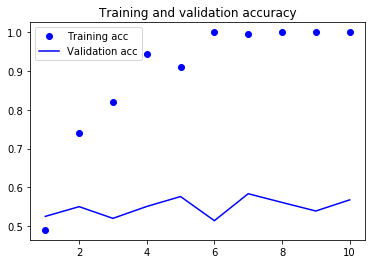

In [16]:
# 코드 6-15 결과 그래프 그리기
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

_그림 6-5. 사전 훈련된 단어 임베딩을 사용했을 때 훈련 손실과 검증 손실_

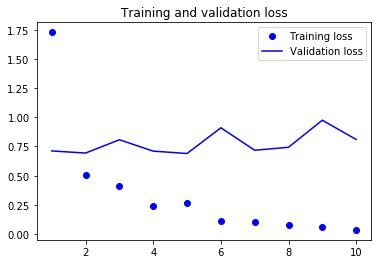

In [17]:
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

_그림 6-6. 사전 훈련된 단어 임베딩을 사용했을 때 훈련 정확도와 검증 정확도_

이 모델은 과대적합이 빠르게 시작됩니다. 훈련 샘플 수가 작기 때문에 놀라운 일은 아닙니다. 같은 이유로 검증 정확도와 훈련 정확도 사이에 차이가 큽니다. 검증 정확도는 50% 후반을 달성한 것 같습니다.

훈련 샘플 수가 적기 때문에 어떤 샘플 200개를 선택했는지에 따라 성능이 크게 좌우됩니다. 여기서는 샘플들을 랜덤하게 선택했습니다. 만약 선택한 샘플에서 성능이 나쁘면 예제를 위해서 랜덤하게 200개의 샘플을 다시 추출하세요(실전에서는 훈련 데이터를 고르지 않습니다).

사전 훈련된 단어 임베딩을 사용하지 않거나 임베딩 층을 동결하지 않고 같은 모델을 훈련할 수 있습니다. 이런 경우 해당 작업에 특화된 입력 토큰의 임베딩을 학습할 것입니다. 데이터가 풍부하게 있다면 사전 훈련된 단어 임베딩보다 일반적으로 훨씬 성능이 높습니다. 여기서는 훈련 샘플이 200개뿐이지만 한 번 시도해 보죠.

In [18]:
# 코드 6-16. 사전 훈련된 단어 임베딩을 사용하지 않고 같은 모델 훈련하기
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 4ms/step - loss: 0.6927 - acc: 0.4850 - val_loss: 0.6928 - val_acc: 0.5151
Epoch 2/10
200/200 [==============================] - 1s 3ms/s

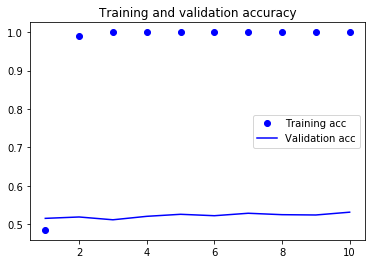

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

_그림 6-7. 사전 훈련된 단어 임베딩을 사용하지 않았을 때 훈련 손실과 검증 손실_

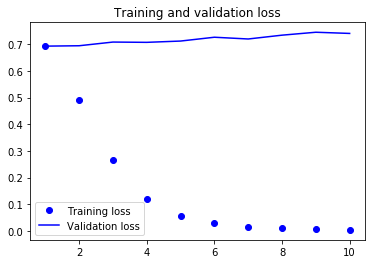

In [20]:
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

_그림 6-8. 사전 훈련된 단어 임베딩을 사용하지 않았을 때 훈련 정확도와 검증 정확도_

검증 정확도는 50% 초반에 멈추어 있습니다. 이 예제에서는 사전 훈련된 단어 임베딩을 사용하는 것이 임베딩을 함께 훈련하는 것보다 낫습니다. 훈련 샘플의 수를 늘리면 금새 상황이 바뀝니다. 연습삼아 한 번 확인해 보세요.

훈련 샘플의 수를 2000개로 늘려서 확인해 보겠습니다.

In [21]:
training_samples = 2000
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

In [22]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Train on 2000 samples, validate on 10000 samples
Epoch 1/10
2000/2000 [==============================] - 1s 450us/step - loss: 0.6355 - acc: 0.6085 - val_loss: 0.6405 - val_acc: 0.6318
Epoch 2/10
2000/2000 [==============================] - 1s 441us/step - loss: 0.1737 - acc: 0.9805 - val_loss: 0.6010 - val_acc: 0.6794
Epoch 3/10
2000/2000 [==============================] - 1s 439us/step - loss: 0.0237 - acc: 0.9990 - val_loss: 0.6176 - val_acc: 0.7009
Epoch 4/10
2000/2000 [==============================] - 1s 450us/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.6776 - val_acc: 0.7068
Epoch 5/10
2000/2000 [==============================] - 1s 440us/step - loss: 1.9983e-04 - acc: 1.0000 - val_loss: 0.7035 - val_acc: 0.7155
Epoch 6/10
2000/2000 [==============================] - 1s 443us/step - loss: 2.2061e-05 - acc: 1.0000 - val_loss: 0.7578 - val_acc: 0.7201
Epoch 7/10
2000/2000 [==============================] - 1s 453us/step - loss: 3.2025e-06 - acc: 1.0000 - val_loss: 0.8288 - val

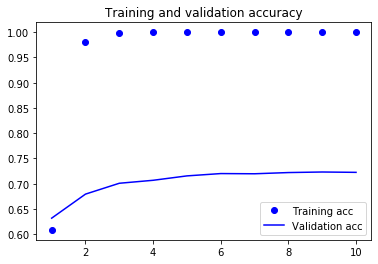

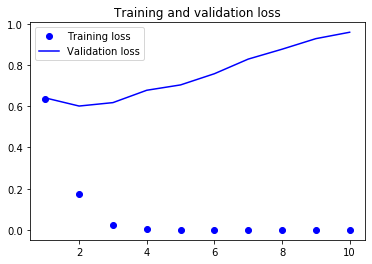

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

훈련 샘플의 수를 늘리니 단어 임베딩을 같이 훈련하는 모델의 검증 정확도가 70%를 넘었습니다.

마지막으로 테스트 데이터에서 모델을 평가해 보죠. 먼저 테스트 데이터를 토큰화해야 합니다.

In [24]:
# 코드 6-17. 테스트 데이터 토큰화하기
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding="utf8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

그다음 이 절의 첫 번째 모델을 로드하고 평가합니다.[^17]

[^17]: 코드 6-14에서 저장한 모델입니다.

In [25]:
# 코드 6-18. 테스트 세트에서 모델 평가하기
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 56us/step


[0.8251172072029114, 0.5580400228500366]

테스트 정확도는 겨우 50% 정도입니다. 적은 수의 훈련 샘플로 작업하는 것은 어려운 일이군요!

## 6.1.4 정리

이제 다음 작업을 할 수 있습니다.

- 원본 텍스트를 신경망이 처리할 수 있는 형태로 변환합니다.
- 케라스 모델에 `Embedding` 층을 추가하여 어떤 작업에 특화된 토큰 임베딩을 학습합니다.
- 데이터가 부족한 자연어 처리 문제에서 사전 훈련된 단어 임베딩을 사용하여 성능 향상을 꾀합니다.